# Chemicals in Cosmetics
# By Abby Hidalgo and Zobe Murray
# Course: CPSC 322, Fall 2024

In [20]:
import importlib

import mysklearn.myevaluation
importlib.reload(mysklearn.myevaluation)
import mysklearn.myevaluation as myevaluation

import mysklearn.myutils
importlib.reload(mysklearn.myutils)
import mysklearn.myutils as myutils

import mysklearn.mypytable
importlib.reload(mysklearn.mypytable)
from mysklearn.mypytable import MyPyTable 

import mysklearn.myclassifiers
importlib.reload(mysklearn.myclassifiers)
from mysklearn.myclassifiers import MyKNeighborsClassifier, MyNaiveBayesClassifier, MyRandomForestClassifier

#import analysis_code.plot_utils
#importlib.reload(analysis_code.plot_utils)
import flask_app.naive_picker
importlib.reload(flask_app.naive_picker)

import flask_app.cosmetic_app
importlib.reload(flask_app.cosmetic_app)

import tabulate
from tabulate import tabulate
import numpy as np

## Introduction:

In this project, the dataset examined is the chemicals in cosmetics set provided by data.gov which reflects the hazardous chemicals that have been reported to the California Safe Cosmetics Program. The number of instances in this dataset is 114,637 instances making it substanitally larger than any other dataset we have worked with previously with 22 different attributes. The attribute types are mainly strings with some numerical attributes inclueded. The attribute being used for the class labeling is chemical names. After many preprocessing steps and modifications were made to scale the dataset to a more approachable size, the best classifier ended up being the Naive Bayes classifier which with more time and experimentation we believe could have been improved further.

### Experiments with Joining Datasets

In [21]:
raw_data = MyPyTable()
raw_data2 = MyPyTable()
X = []
Y = []
raw_data = raw_data.load_from_file("california_cosmetics.csv")
raw_data2 = raw_data2.load_from_file("cosmetics_kaggle.csv")
data_joined = raw_data.perform_inner_join(raw_data2, ["BrandName"])
duplicates = data_joined.find_duplicates(["BrandName"])
data_joined.drop_rows(duplicates)
data_joined.save_to_file("cosmetics_clean.csv")
row, col = data_joined.get_shape()
print("number of rows ", row)
print("number of cols ", col)

number of rows  13
number of cols  32


Orignallt, we had planned to make a comparison between the california cosmetics dataset and the cosmetics kaggle dataset, but based on the lack of overlaping data, we decided to move away from using the cosmetics kaggle data set and instead are splitting the data set in order to test our classifiers. The size of our dataset is sufficient due to it being more than 100,000 entries that need to be sorted through.

## Data Analysis:

The dataset contains 114635 instances and 22 different attributes in its original form. Some of these attributes are the date a hazardous chemical was reported to be in a a production while others are the name of the company that produced a product with said chemical. For the purpose of our analysis, all of our attributes used were strings. The attribute used as the label is the chemical name. The most important data visualization that we included was the frequency diagram in which we show the distribution of our newly smoothed dataset.

### Cleaning Data

In [22]:
subset = MyPyTable().load_from_file("california_cosmetics_removed_columns.csv")
row, col = subset.get_shape()
print("number of rows ", row)
print("number of cols ", col)

number of rows  114635
number of cols  6


For this we needed to pull a subset of data from the california cosmetics data set since the processing time of the whole set took too long for the project to be efficient. In the removed columns spreadsheet we reduced the number of attributes to 6, but kept the 114,635 instances. The narrowing down of the data helped us run it in a more efficient time.

In [23]:
subset = subset.remove_rows_with_missing_values()
row, col = subset.get_shape()
print("number of rows ", row)
print("number of cols ", col)

number of rows  114595
number of cols  6


This code block removes rows with missing values in any of these attribute fields. This slightly trims the data set. 

### Examining Initial Frequency of Chemical Types

In [24]:
y = subset.get_column("ChemicalName")

In [25]:
unique_vals, counts = myutils.get_frequency(y)
print(unique_vals)
print(counts)
drugs = []
for i, val in enumerate(unique_vals):
    if counts[i] > 1000:
        drugs.append(val)

print(drugs)
index = subset.column_names.index("ChemicalName")
subset2 = MyPyTable()
subset2.column_names = subset.column_names
for inst in subset.data:
    for drug in drugs:
        if inst[index] == drug:
            subset2.data.append(inst)
y2 = subset2.get_column("ChemicalName")
chemical_indices = myutils.group_by(y2)

['1,4-Dioxane', '2,2-Bis(bromomethyl)-1,3-propanediol', '2,4-Hexadienal (89% trans, trans isomer; 11% cis, trans isomer)', '2-Propyleneacrolein', 'Acetaldehyde', 'Acetic acid, retinyl ester', 'Acetylsalicylic acid', 'Acrylamide', 'All-trans retinoic acid', 'Aloe vera, non-decolorized whole leaf extract', 'Aloe vera, whole leaf extract', 'Arsenic (inorganic arsenic compounds)', 'Arsenic (inorganic oxides)', 'Aspirin', 'Avobenzone', 'Benz[a]anthracene', 'Benzene', 'Benzo[a]pyrene', 'Benzophenone', 'Benzophenone-2', 'Benzophenone-3', 'Benzophenone-4', 'Benzyl chloride', 'Bisphenol A (BPA)', 'Butylated hydroxyanisole', 'C.I. Acid Red 114', 'Cadmium and cadmium compounds', 'Caffeic acid', 'Caffeine', 'Carbon black', 'Carbon black (airborne, unbound particles of respirable size)', 'Carbon-black extracts', 'Chromium (hexavalent compounds)', 'Coal Tar', 'Coal tar extract', 'Coal tar solution', 'Coal tars', 'Cocamide', 'Cocamide DEA', 'Cocamide MEA', 'Cocamide diethanolamine', 'Cocamide diethan

These code blocks examine the general distribution of the different chemicals and their frequencies in the dataset. This then allowed us to smooth the dataset so it was not so skewed. 

In [26]:
np.random.seed(0)
chosen_indices = []
for chemical in chemical_indices:
    if len(chemical) < 2000:
        chosen_indices.append(chemical)
    else:
        indices = np.random.choice(chemical, 2000, False)
        chosen_indices.append(indices)
for chemical in chosen_indices:
    print(len(chemical))

1888
1758
1362
1918
2000
1181
2000
1548
2000


In this code block we pick the 9 chemical names with the most frequent occurences in the data set and cap the number of instances for each label to 2000 instances.

In [27]:
final_subset = MyPyTable()
final_subset.column_names = subset.column_names
for chemical in chosen_indices:
    for inst in chemical:
        final_subset.data.append(subset2.data[inst])
final_subset.save_to_file("final_subset.csv")
final_y = final_subset.get_column("ChemicalName")
for i, chem in enumerate(final_y):
    if chem == "Retinol/retinyl esters, when in daily dosages in excess of 10,000 IU, or 3,000 retinol equivalents.":
        final_y[i] = "Retinol/retinyl esters"
    elif chem == "Silica, crystalline (airborne particles of respirable size)":
        final_y[i] = "Silica"

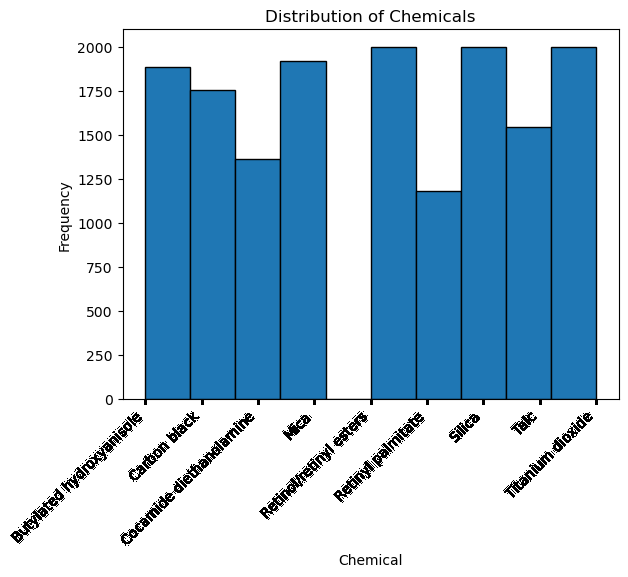

In [28]:
myutils.histogram(final_y, "Chemical", "Frequency", "Distribution of Chemicals", xticks=final_y)

This figure shows a frequency diagram which represents the general distribution of chemical names with Titanium Dioxide, Silica, and Retinol/retinyl esters having the highest frequency of 2000 in the data set. This step allowed us to make sure the data we processed was not too heavily skewed before feeding it to the different classifiers.

### Training classifiers

We chose to narrow down the attributes to predict on to Company Name, Brand Name, Primary Category and Sub Category in order to improve the predictive accuracy of our classifiers, as well as streamline the time it takes for a classifier to make predicts. If we had decided to go with the full data set then more computing power would be needed to even run the program in an efficient amount of time.

In [29]:
final_X = final_subset.get_col_for_pred(["CompanyName", "BrandName", "PrimaryCategory", "SubCategory"])

In [30]:
#initializing classifiers
naive_class = MyNaiveBayesClassifier()
knn_class = MyKNeighborsClassifier()
#splitting data
split = myevaluation.stratified_kfold_split(final_X, final_y, 10, 0)
y_tests = []
y_pred_naive = []
#training the data and then predicting on test sets
for fold in split:
    X_train, X_test, y_train, y_test = myutils.get_train_test(final_X, final_y, fold)
    naive_class.fit(X_train, y_train)
    y_pred_naive.extend(naive_class.predict(X_test))
    y_tests.extend(y_test)

This code block uses stratified 10 fold split and feeds these splots to the naive bayes classifier as well as the knn classifier.

## Classification Results:

For the classification process we used a stratified 10 fold split that gave training and testing data to both the naive bayes classifier and the knn classifier. Ths classifiication only took place after smooting the original data set to get rid of the skew. We found that classification worked best for this still large 15,655 instance new dataset. We performed predictions on the four most relevant attributes that had no empty rows which were company name, brand name, primary category and subcategory. Primary and subcategory in this context could refer to Skin care products and Cleansers respectively. Since all of the data that was passed into the classifiers were categorical attributes no discretization or normalization was needed for this data set. We evlauated our classifiers on accuracy, error rate, precision, f1 score and recognition rates. The classifiers did not perform as well as we had hoped, however with a large variance in categorical attributes and the overall size of the datset we used it does make sense that there is such a variance. The classifier we deemed to be the "best" was the Naive Bayes classifier which was is discussed more below.

In [31]:
#printing the metrics
print("================================================")
print("Naive Bayes Metrics")
print("================================================")
myutils.print_metrics(y_pred_naive, y_tests)

Naive Bayes Metrics
Accuracy: 0.61
Error Rate: 0.39
Precision: 0.86
Recall: 0.69
F1 Score: 0.77
Confusion Matrix:
                            Butylated hydroxyanisole    Carbon black    Cocamide diethanolamine    Mica    Retinol/retinyl esters    Retinyl palmitate    Silica    Talc    Titanium dioxide    Total  Recognition (%)
------------------------  --------------------------  --------------  -------------------------  ------  ------------------------  -------------------  --------  ------  ------------------  -------  -----------------
Butylated hydroxyanisole                        1311              12                         18      37                       140                   64        40      48                 218     1888  69.44%
Carbon black                                       4             650                          0     142                        82                   17       250      34                 579     1758  36.97%
Cocamide diethanolamine                   

While the accuracy of this classifier is a bit discouraging we do need to keep in mind that if we had scaled down the data set even more the classifier could increase in accuracy. With the abundance of categorical options for the classifier to choose between it does make sense that the accuracy could be low, however, recognition rates such as the ones for Retinols and Silica show promising results of classification as well as the high precision score that was given.

In [32]:
knn_class = MyKNeighborsClassifier()
#splitting data
split = myevaluation.stratified_kfold_split(final_X, final_y, 10, 0)
y_tests = []
y_pred_knn = []
#training the data and then predicting on test sets
for fold in split:
    X_train, X_test, y_train, y_test = myutils.get_train_test(final_X, final_y, fold)
    knn_class.fit(X_train, y_train)
    y_pred_knn.extend(knn_class.predict(X_test))
    y_tests.extend(y_test)

In [33]:
print("================================================")
print("kNN Metrics")
print("================================================")
myutils.print_metrics(y_pred_knn, y_tests)

kNN Metrics
Accuracy: 0.46
Error Rate: 0.54
Precision: 0.23
Recall: 0.63
F1 Score: 0.34
Confusion Matrix:
                            Butylated hydroxyanisole    Carbon black    Cocamide diethanolamine    Mica    Retinol/retinyl esters    Retinyl palmitate    Silica    Talc    Titanium dioxide    Total  Recognition (%)
------------------------  --------------------------  --------------  -------------------------  ------  ------------------------  -------------------  --------  ------  ------------------  -------  -----------------
Butylated hydroxyanisole                        1191              77                          0       0                        83                    3        29      20                 485     1888  63.08%
Carbon black                                     569             555                          0      10                         0                    3       121      58                 442     1758  31.57%
Cocamide diethanolamine                          9

In comparison, the Naive Bayes classifier performed bounds better than the knn classifier. Judging by the accuracy alone Naive Bayes boasts an accuracy of 68% in comparison to the knn accuracy of 46%. Additionally, the recognition rates even fell with that of the Retinols now being 79.70% instead of the 89.755% that it was for Naive Bayes.

In [34]:
tree_class = MyRandomForestClassifier()
#splitting data
split = myevaluation.stratified_kfold_split(final_X, final_y, 3, 0)
y_pred_tree = []
#training the data and then predicting on test sets
X_train, X_test, y_train, y_test = myutils.get_train_test(final_X, final_y, split[0])
tree_class.fit(X_train, y_train, 20, 2, 7)
y_pred_tree = tree_class.predict(X_test)

TypeError: 'NoneType' object is not iterable

In [ ]:
#printing the classification report (bonus)
print("================================================")
print("Naive Bayes Report")
print("================================================")
print(myevaluation.classification_report(y_tests, y_pred_naive, False))
print("================================================")
print("kNN Report")
print("================================================")
print(myevaluation.classification_report(y_tests, y_pred_knn, False))

Naive Bayes Report
+-----------------------------------------------------------------------------------------------------+-------------+----------+------------+-----------+
|                                                                                                     | precision   | recall   |   f1-score |   support |
+=====================================================================================================+=============+==========+============+===========+
| Butylated hydroxyanisole                                                                            | 0.0         | 0.0      |       0    |         2 |
+-----------------------------------------------------------------------------------------------------+-------------+----------+------------+-----------+
| Chromium (hexavalent compounds)                                                                     | 0.0         | 0.0      |       0    |         1 |
+--------------------------------------------------------

## Classification Web App

To run the flask app you need to run the cosmetic_app.py file visit the link given when running to ensure the landing page appears and then for example, you can click the link in cosmetic_data.py to see the prediction that the model makes based on the query string given. You then should be taken to a page that displays the prediction for the unseen instance.

## Conclusion 

Overall, our biggest challenge with this dataset was deciding what a reasonable distribution of data looked like and how to optimize the run time for each of the classifiers on such a large set of data. We were extremely interested in using a larger dataset because we have never worked with data in this large of a scope before. The classification approach that helped us was narrowing the data set down to only 9 possible class labels, 6 instances, just above 15000 instances and giving our classifiers the same testing and training data (except for random forest). The performance of these classifiers could be improved by narrowing down the possible class labels, instances and possibly introducing one or two more attributes to help refine searches.

## Acknowledgements:

Kaggle dataset used in experiment: https://www.kaggle.com/datasets/kingabzpro/cosmetics-datasets?resource=download

California Cosmetics Dataset: https://catalog.data.gov/dataset/chemicals-in-cosmetics-c4363